In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"

In [2]:
import os
import sys
import inspect


parentdir = os.path.dirname('../')
sys.path.insert(0, parentdir)




In [3]:
import torch
from torch import nn
import numpy as onp
from tqdm import trange, tqdm
from IPython.display import clear_output

In [4]:
from process_data import process_data

In [5]:
from jax import random, jit, vmap, numpy as jnp
import jax
from flax.training import train_state, checkpoints

from torch.utils.data import Dataset, DataLoader, random_split
from flax import linen as nn

import optax

from typing import Sequence

In [6]:
cols, data = process_data('../bld1.csv', exclude_settemp=True)
idx_temperature = onp.array(['Zone Air Temperature'in col for col in cols])
idx_predictive = onp.array(['Zone Air Temperature' in col or 'Zone Air Humidity Ratio' in col for col in cols])

Y = data[cols[idx_temperature]]
# X = data[cols[~idx_temperature]]
X = data

/scratch/wangh19/CSE23Hackathon/hanwen/../process_data.py:9: DtypeWarning: Columns (10,14,20,22,35,36,37,38,39,40,41,42,43,44,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)


In [7]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y, lags):
        self.X = X
        self.Y = Y
        self.lags = lags

    def __getitem__(self, index):
        return self.X[index:(index+self.lags)], self.Y[(index+self.lags)] 


    def __len__(self):
        return self.X.shape[0]-self.lags-1


In [8]:
batch_size = 128
lags = 5
dataset = TimeSeriesDataset(onp.array(X), onp.array(Y), lags)
train_dataset, test_dataset, validation_dataset = random_split(dataset, [0.89, 0.1, 0.01], generator=torch.Generator().manual_seed(0))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size//4)

In [9]:
for batch in train_loader:
    batch = [jnp.array(f) for f in batch]
    X_lags, y_target = batch
    break

In [10]:
hidden_size = 512
key = random.PRNGKey(0)
class LSTMScan(nn.Module):
  out_dim : int
  @nn.compact
  def __call__(self, c, xs):
    LSTM = nn.scan(nn.OptimizedLSTMCell,
                   variable_broadcast="params",
                   split_rngs={"params": False},
                   in_axes=1,
                   out_axes=1)
    out_carry, out_val = LSTM()(c, xs)
    return out_carry, nn.Dense(self.out_dim)(out_val[:,-1])


key_1, key_2, key_3, key = random.split(key, 4)

xs = random.uniform(key_1, (batch_size, 2, X_lags.shape[-1]))
init_carry = nn.OptimizedLSTMCell.initialize_carry(key_2, (batch_size,), hidden_size)

net = LSTMScan(y_target.shape[-1])
params = net.init(key_3, init_carry, xs)
out_carry, out_val = net.apply(params, init_carry, xs)

In [11]:
hidden_size = 512
key = random.PRNGKey(0)
class LSTMScan(nn.Module):
  out_dim : int
  @nn.compact
  def __call__(self, c, xs):
    LSTM = nn.scan(nn.OptimizedLSTMCell,
                   variable_broadcast="params",
                   split_rngs={"params": False},
                   in_axes=1,
                   out_axes=1)
    out_carry, out_val = LSTM(jax.nn.gelu)(c, xs)
    return out_carry, nn.Dense(self.out_dim)(out_val[:,-1])


key_1, key_2, key_3, key = random.split(key, 4)

xs = random.uniform(key_1, (batch_size, 2, X_lags.shape[-1]))
init_carry = nn.OptimizedLSTMCell.initialize_carry(key_2, (batch_size,), hidden_size)

net = LSTMScan(y_target.shape[-1])
params = net.init(key_3, init_carry, xs)
out_carry, out_val = net.apply(params, init_carry, xs)

In [12]:
@jit
def train_step(state, batch, carry_key = random.PRNGKey(0)):
  sequence, targets = batch
  def loss_fn(params):
    init_carry = nn.OptimizedLSTMCell.initialize_carry(carry_key, (sequence.shape[0],), hidden_size)
    out_carry, out_val = state.apply_fn(params, init_carry, sequence)
    loss = ((out_val - targets)**2).mean() 
    return loss
  grad_fn = jax.value_and_grad(loss_fn, has_aux=False)
  loss, grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state, loss

@jit
def prediction(state, sequence, carry_key = random.PRNGKey(0)):
    init_carry = nn.OptimizedLSTMCell.initialize_carry(carry_key, (sequence.shape[0],), hidden_size)
    out_carry, out_val = state.apply_fn(params, init_carry, sequence)

    return out_carry, out_val


In [13]:
optimizer = optax.adam(learning_rate=1e-3)
state = train_state.TrainState.create(
  apply_fn=net.apply,
  params=params,
  tx=optimizer
)

In [14]:
for e in range(100):
    clear_output(wait = True)
    pbar = tqdm(train_loader)
    for k, batch in enumerate(pbar):
        
        batch = [jnp.array(f) for f in batch]
        state, loss = train_step(state, batch)
        
        if k % 100 == 0:
            pbar.set_postfix(dict(epoch = e, loss = loss.item()))

100%|██████████| 366/366 [00:07<00:00, 52.02it/s, epoch=99, loss=56.5]


In [15]:
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size//4)
pbar = tqdm(train_loader)

predictions = []
targets = []
for k, batch in enumerate(pbar):

    batch = [jnp.array(f) for f in batch]
    sequence, target = batch
    _, pred = prediction(state, sequence)

    predictions.append(pred)
    targets.append(target)



100%|██████████| 366/366 [00:07<00:00, 48.68it/s]


In [16]:
predictions = jnp.concatenate(predictions, 0)
targets = jnp.concatenate(targets, 0)

print(jnp.linalg.norm(predictions - targets) / jnp.linalg.norm(targets))

25.008684


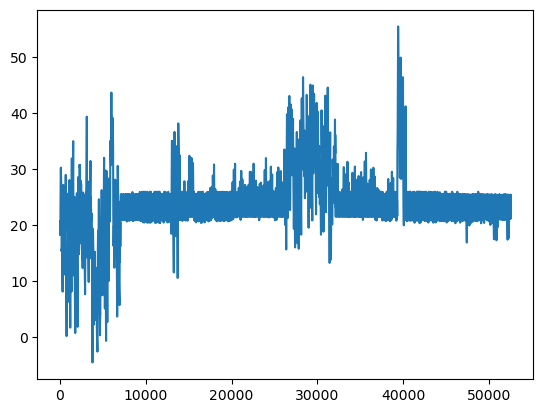

In [17]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(jnp.array(Y)[:,0])
plt.show()
plt.close()